# Exploring New Alloy Systems with Pymatgen!

#### 
#### Author: Rachel Woods-Robinson
#### Version: July 27, 2020
#### 

<img src="goals.png" style="max-width:50%">

### 
### Lesson contents:
1. Select a test-case system (e.g. ZnS)
    - Exercise: Structure and API refresher
2. Select an alloy partner (e.g. Cu)
    - Lesson: Find possible dopants
    - Exercise: Find the best alloy partner
    - Lesson: Explore phase diagrams!
3. Transform to make a new alloy
    - Lesson: Substitute and transform
    - Exercise: Transform for another composition
4. Calculate new properties
    - Lesson: Guess lattice parameters and compare XRD
    - Exercise: Plot XRD for your composition

# 
# 1. Select a test-case system

### EXERCISE: Structure and API refresher!

- Get ZnS structure information
- Add oxidation states
- Get space group info?

#### Initiate the API with your API key

###### Import the MP Rester

In [1]:
from pymatgen import MPRester

###### Now, we can initiate the MP Rester API by creating an object mpr:

In [2]:
mpr = MPRester("4dM3PFrLKxptsm6A") # YOUR API KEY GOES IN THIS FUNCTION! as a string.

#### In this notebook we will focus on cubic zinc-blende ZnS, a wide band gap (transparent) semiconductor. In my PhD research I study p-type transparent semiconductors, so I will pose the question: how can we use ZnS as a starting point to create a p-type transparent semiconductor?

###### Materials Project ID (mpid) of zinc-blende ZnS: https://materialsproject.org/materials/mp-10695/

In [3]:
ZnS_mpid = "mp-10695"

#### 
#### Get the structure

In [4]:
ZnS_structure = mpr.get_structure_by_material_id("mp-10695")

In [5]:
## if you're having problems with your internet or API key

# from monty.serialization import loadfn
# ZnS_structure = loadfn("ZnS_structure.json")

In [6]:
ZnS_structure.get_space_group_info()

('F-43m', 216)

###### 
###### Check it out on our web app here: http://app.crystaltoolkit.org/mp-10695

- Click "Draw atoms outside unit cell bonded to atoms within unit cell"
- Play around with it!

### LESSON: add oxidation state to structure

###### Pymatgen has a simple transformation to guess the oxidation state of each specie in stoichiometric compounds. This information is needed to compare ionic radii and assess substitutional dopact probability. You can also enter the oxidation states manually if you'd prefer.

In [7]:
from pymatgen.transformations.standard_transformations import AutoOxiStateDecorationTransformation

###### Initialize the transformation

In [8]:
oxi_transformation = AutoOxiStateDecorationTransformation()

In [9]:
ZnS_structure_oxi = oxi_transformation.apply_transformation(ZnS_structure)

In [10]:
print(ZnS_structure_oxi)

Full Formula (Zn1 S1)
Reduced Formula: ZnS
abc   :   3.853923   3.853923   3.853923
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP       a     b     c    magmom
---  ----  ----  ----  ----  --------
  0  Zn2+  0     0     0            0
  1  S2-   0.25  0.25  0.25        -0


### 
### Bonus: plot band structure

In [11]:
from pymatgen.electronic_structure.plotter import BSPlotter

In [12]:
ZnS_bs = mpr.get_bandstructure_by_material_id(ZnS_mpid)

###### 
###### Initialize the band structure plotter

In [13]:
ZnS_bsp = BSPlotter(ZnS_bs)

###### 
###### Get plot

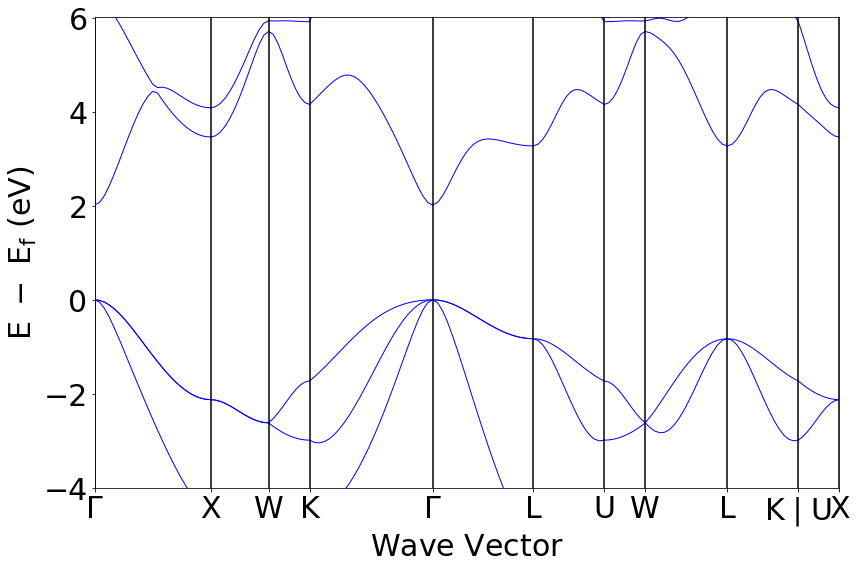

In [14]:
ZnS_bsp.show() # takes a second

### 
### Bonus: Band gap correction

In [15]:
ZnS_bs.get_band_gap()

{'direct': True, 'energy': 2.0186, 'transition': '\\Gamma-\\Gamma'}

###### 
###### ZnS has an experimental gap of approximately 3.5 eV, but the GGA calculated gap is far too low!
###### We can apply a "scissor" to this band structure to correct for this

In [16]:
ZnS_bs_scissor = ZnS_bs.apply_scissor(new_band_gap=3.5)

In [17]:
ZnS_bsp_scissor = BSPlotter(ZnS_bs_scissor)

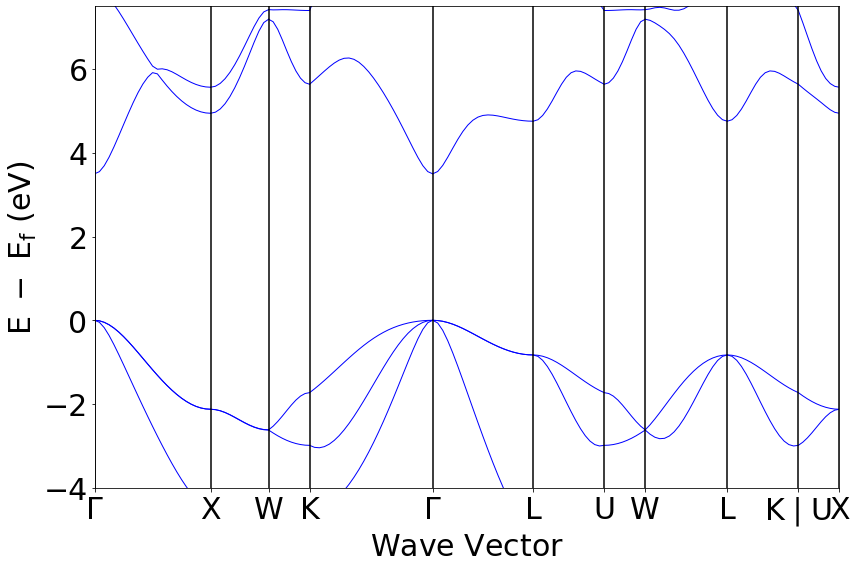

In [18]:
ZnS_bsp_scissor.show()

# 
# 2. Select an alloy partner

#### 
#### $\textit{Scientific question: Which p-type dopants are most likely to sit at substitutional in ZnS?}$

### LESSON: Find possible dopants

###### Pymatgen has a machine-learned method for estimating the probability that one ion will substitute for another (Hautier et al.), and reports the results ranked in order of probability. Note the input structure has to be "decorated" with oxidation states

In [19]:
from pymatgen.analysis.structure_prediction.dopant_predictor import get_dopants_from_substitution_probabilities

In [20]:
substitutional_dopants = get_dopants_from_substitution_probabilities(
    ZnS_structure_oxi, num_dopants=10)

###### Here are some options to dope ZnS p-type

In [21]:
p_dopants = substitutional_dopants['p_type']

In [22]:
import pandas as pd

In [23]:
pd.DataFrame(p_dopants)

,probability,dopant_species,original_species
0,0.035178,Na+,Zn2+
1,0.029318,Cu+,Zn2+
2,0.018723,N3-,S2-
3,0.016421,K+,Zn2+
4,0.015108,Li+,Zn2+
5,0.005241,Ag+,Zn2+
6,0.005069,O2-,Zn2+
7,0.002676,Au+,Zn2+
8,0.002676,Rb+,Zn2+
9,0.002676,Tl+,Zn2+


#### 
#### $\textit{Scientific question: is a p-type zinc-blende $A_{x}Zn_{1-x}S$ alloy possible?}$

### EXERCISE: Find the best alloy partner (A = ?)

###### Let's see if zinc-blende binaries exist for these ternaries, and how far off the hull they sit

In [24]:
possible_cation_dopants = []
for x in p_dopants:
    specie = x["dopant_species"]
    if specie.oxi_state > 0:
        possible_cation_dopants.append(str(specie.element))

In [25]:
possible_cation_dopants

['Na', 'Cu', 'K', 'Li', 'Ag', 'Au', 'Rb', 'Tl']

###### Note: get query tags here https://github.com/materialsproject/mapidoc/tree/master/materials

In [26]:
query = mpr.query({
        # input query tags
        "elements": {"$all": ["S"], "$in": possible_cation_dopants},
        "nelements": 2,
        "spacegroup.symbol": "F-43m"},

        # output query tags
        ["task_id", "e_above_hull", "pretty_formula", "icsd_ids"]
         )

In [27]:
pd.DataFrame(query)

,task_id,e_above_hull,pretty_formula,icsd_ids
0,mp-760381,0.012687,CuS,[]
1,mp-28963,0.267027,Ag8S,[]


###### Only Cu! ($Ag_8S$ is a theroetical intermetallic) CuS is a theoretical compound and is not on the hull, but it's close. Ok, so let's pick Cu$^{+}$ to use as a p-type dopant (see Woods-Robinson et al. 2019, https://doi.org/10.1016/j.matt.2019.06.019)

#### Check the space group of CuS

In [28]:
CuS_mpid = query[0]["task_id"]
print(CuS_mpid)

mp-760381


In [29]:
CuS_structure = mpr.get_structure_by_material_id(CuS_mpid)

In [67]:
CuS_structure.get_space_group_info()

('F-43m', 216)

##### We’re not done, but this is a starting point for dopants to investigate with defect calculations !! This can be accomplished using workflows such as PyCDT (Broberg et al. 2018), which we are working on implementing via atomate.

### 
### Bonus: Plot CuS band structure

In [30]:
CuS_bs = mpr.get_bandstructure_by_material_id(CuS_mpid)

In [31]:
CuS_bs.get_band_gap()

{'energy': 0.0, 'direct': False, 'transition': None}

In [32]:
CuS_bsp = BSPlotter(CuS_bs)

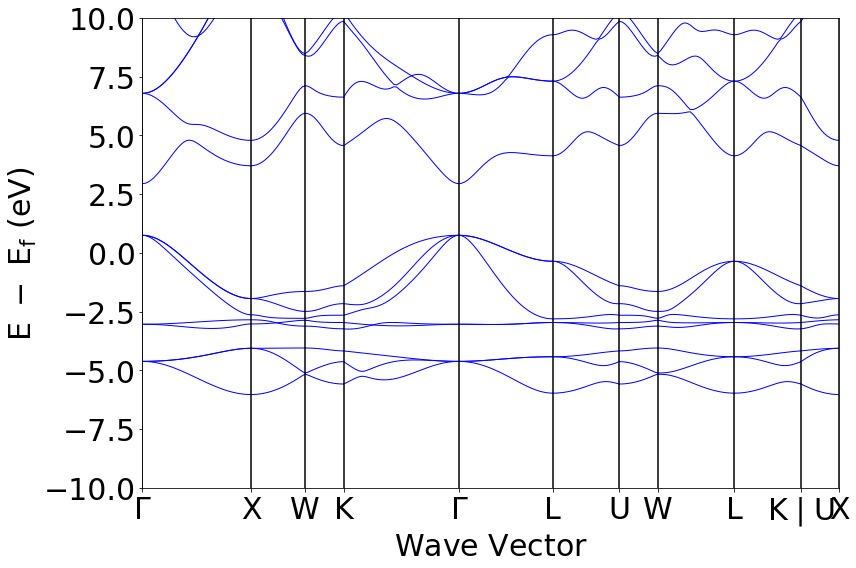

In [33]:
CuS_bsp.show()

In [34]:
key = list(CuS_bs.bands.keys())[0]
bands = CuS_bs.bands[key]
Cu_gap_ish = bands[7].min() - bands[6].max()

In [35]:
def gap(x):
    return 3.5 * (1 - x) + 0.805 * (1.5) * (x)

In [36]:
gap(1/4)

2.926875

#### 
#### $\textit{Scientific question: what does Cu-Zn-S phase space look like?}$

### LESSON: Explore phase diagrams!

In [68]:
from pymatgen.analysis.phase_diagram import GrandPotPDEntry, PhaseDiagram, PDPlotter, CompoundPhaseDiagram, GrandPotentialPhaseDiagram

In [69]:
entries = mpr.get_entries_in_chemsys(['Cu', 'Zn', 'S'])

In [70]:
phase_diagram = PhaseDiagram(entries)

#### Simple phase diagram

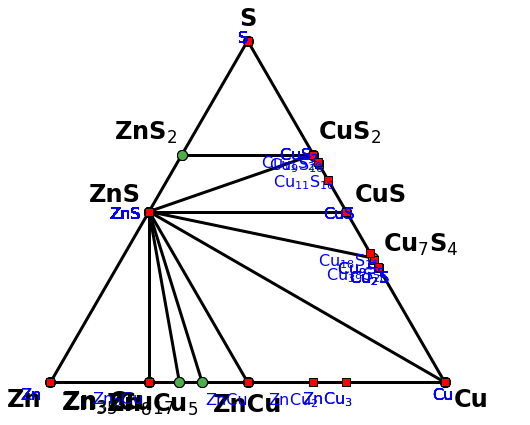

In [71]:
plotter = PDPlotter(phase_diagram, show_unstable=True)
plotter.show()

#### 
#### Formation enthalpies referenced to elements

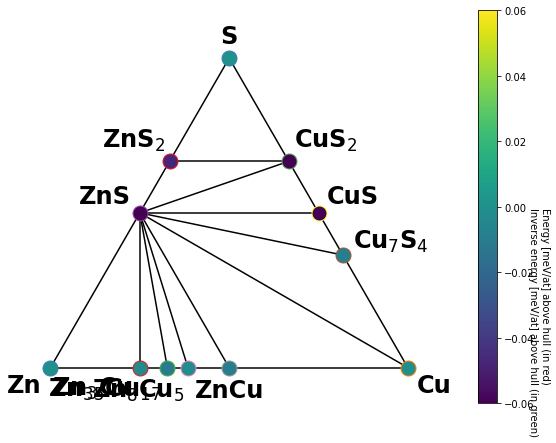

In [73]:
plotter = PDPlotter(phase_diagram, show_unstable=False)
x = plotter.get_plot(phase_diagram, label_unstable=False, energy_colormap='viridis')
x.show()

#### Mapping out chemical potential of cations

In [44]:
from pymatgen import Element

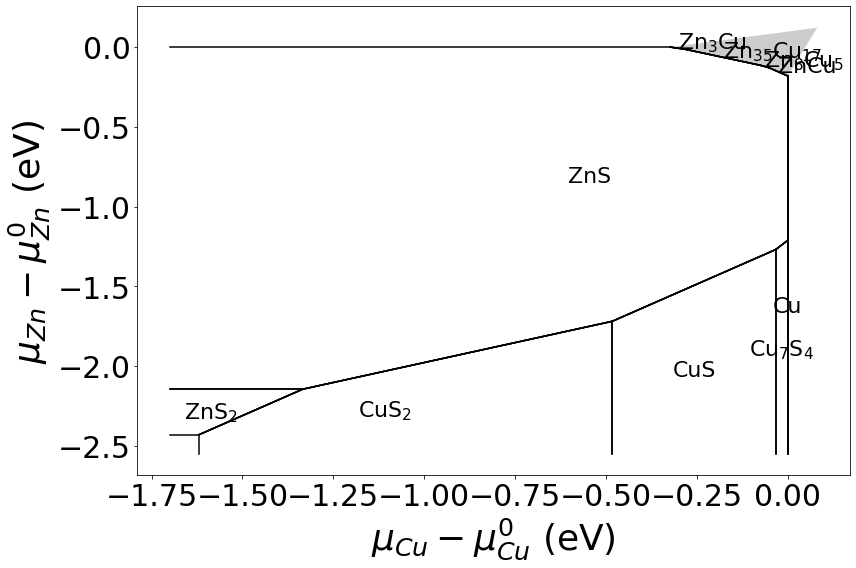

In [45]:
plotter.get_chempot_range_map_plot([Element("Cu"), Element("Zn")]).show()

##### 
##### Ternary space is EMPTY!! So let's fill it in...

# 
# 3. Transform to make a new alloy

### 
### LESSON: Substitute your dopant to create a disordered structure

###### 
###### Now, so let's substitute 1/4 of the Zn$^{2+}$ with Cu$^{+}$ (note: we will be ignoring charge compensation here, but this is important to take into account in real calculations!)

In [46]:
substitution_fraction = 0.25

In [47]:
disordered_structure = ZnS_structure_oxi.copy()
disordered_structure.replace_species(
    {"Zn2+": {"Cu+": substitution_fraction,
                         "Zn2+": 1 - substitution_fraction}}
)

In [48]:
print(disordered_structure)

Full Formula (Zn0.75 Cu0.25 S1)
Reduced Formula: Zn0.75Cu0.25S1
abc   :   3.853923   3.853923   3.853923
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP                        a     b     c    magmom
---  ---------------------  ----  ----  ----  --------
  0  Zn2+:0.750, Cu+:0.250  0     0     0            0
  1  S2-                    0.25  0.25  0.25        -0


In [49]:
# if you want to download this file

disordered_structure.to("cif", "disordered_structure.cif")

###### 
###### Screen shot of disordered structure

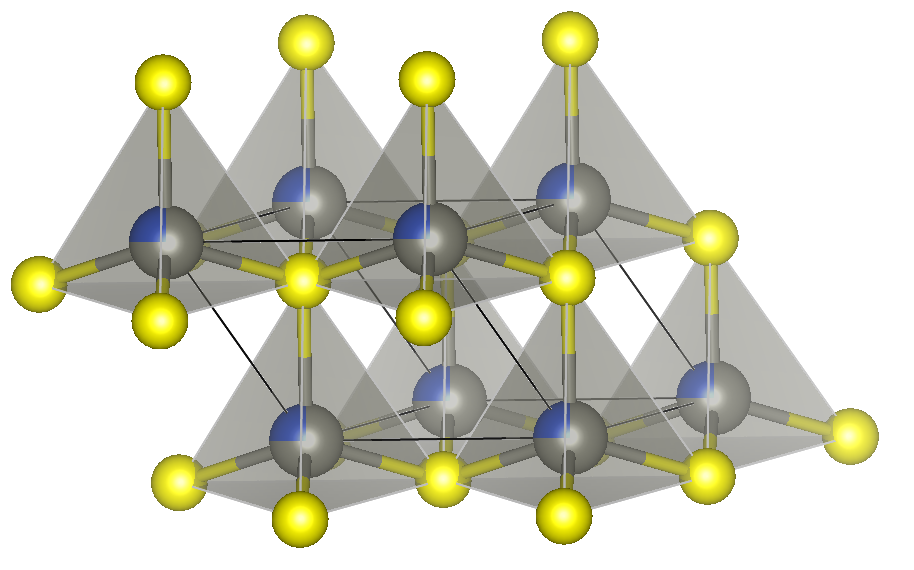

#### 
#### Make a supercell

Our structure is a "disordered crystal structure", where each site has partial occupancy of a Zn and Cu atom. Though disorder may indeed be more representative of a real crystal structure, we need to convert this to an ordered structure to perform DFT calculations. To do this, we create a disordered supercell and then perform a disorder-to-order transformation

In [50]:
substitution_fraction

0.25

In [51]:
disordered_supercell = disordered_structure * [2, 2, 2]

In [52]:
print(disordered_supercell)

Full Formula (Zn6 Cu2 S8)
Reduced Formula: Zn3CuS4
abc   :   7.707846   7.707846   7.707846
angles:  60.000000  60.000000  60.000000
Sites (16)
  #  SP                         a      b      c    magmom
---  ---------------------  -----  -----  -----  --------
  0  Zn2+:0.750, Cu+:0.250  0      0      0             0
  1  Zn2+:0.750, Cu+:0.250  0      0      0.5           0
  2  Zn2+:0.750, Cu+:0.250  0      0.5    0             0
  3  Zn2+:0.750, Cu+:0.250  0      0.5    0.5           0
  4  Zn2+:0.750, Cu+:0.250  0.5    0      0             0
  5  Zn2+:0.750, Cu+:0.250  0.5    0      0.5           0
  6  Zn2+:0.750, Cu+:0.250  0.5    0.5    0             0
  7  Zn2+:0.750, Cu+:0.250  0.5    0.5    0.5           0
  8  S2-                    0.125  0.125  0.125        -0
  9  S2-                    0.125  0.125  0.625        -0
 10  S2-                    0.125  0.625  0.125        -0
 11  S2-                    0.125  0.625  0.625        -0
 12  S2-                    0.625  0.125  0.

#### 
#### Transform structure

Pymatgen supports a variety of structural "transformations." A list of supported transformations is available https://pymatgen.org/pymatgen.transformations.html.

###### 
###### Here are three methods to take a disordered structure, and order it:

1. OrderDisorderStructureTransformation
2. EnumerateStructureTransformation: uses enumlib
3. SQSTransformation: uses ATAT, a code for creating special quasirandom structures (SQS)

###### 
###### For this demo, we'll be focusing on the most simple transformation: OrderDisorderStructureTransformation

In [53]:
from pymatgen.transformations.advanced_transformations import OrderDisorderedStructureTransformation

In [54]:
odst = OrderDisorderedStructureTransformation(no_oxi_states=False)

In [55]:
ordered_structures = odst.apply_transformation(disordered_supercell,
                                             return_ranked_list = 10)

In [56]:
ordered_structures

[{'energy': -285.4743424481398,
  'energy_above_minimum': 0.0,
  'structure': Structure Summary
  Lattice
      abc : 7.707845752595208 7.707845752595208 7.707845752595208
   angles : 59.99999999999999 59.99999999999999 59.99999999999999
   volume : 323.8053704338693
        A : 0.0 5.45027 5.45027
        B : 5.45027 0.0 5.45027
        C : 5.45027 5.45027 0.0
  PeriodicSite: Zn2+ (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
  PeriodicSite: Zn2+ (2.7251, 0.0000, 2.7251) [0.0000, 0.5000, 0.0000]
  PeriodicSite: Zn2+ (5.4503, 2.7251, 2.7251) [0.0000, 0.5000, 0.5000]
  PeriodicSite: Zn2+ (0.0000, 2.7251, 2.7251) [0.5000, 0.0000, 0.0000]
  PeriodicSite: Zn2+ (2.7251, 5.4503, 2.7251) [0.5000, 0.0000, 0.5000]
  PeriodicSite: Zn2+ (5.4503, 5.4503, 5.4503) [0.5000, 0.5000, 0.5000]
  PeriodicSite: Cu+ (2.7251, 2.7251, 0.0000) [0.0000, 0.0000, 0.5000]
  PeriodicSite: Cu+ (2.7251, 2.7251, 5.4503) [0.5000, 0.5000, 0.0000]
  PeriodicSite: S2- (1.3626, 1.3626, 1.3626) [0.1250, 0.1250, 0.1250]


###### 
###### This is a list of ten structures ranked by Ewald sum ("energy")
###### 
###### Let's just use the first entry for our example

In [57]:
ordered_structure = ordered_structures[0]["structure"]

In [58]:
print(ordered_structure)

Full Formula (Zn6 Cu2 S8)
Reduced Formula: Zn3CuS4
abc   :   7.707846   7.707846   7.707846
angles:  60.000000  60.000000  60.000000
Sites (16)
  #  SP        a      b      c    magmom
---  ----  -----  -----  -----  --------
  0  Zn2+  0      0      0             0
  1  Zn2+  0      0.5    0             0
  2  Zn2+  0      0.5    0.5           0
  3  Zn2+  0.5    0      0             0
  4  Zn2+  0.5    0      0.5           0
  5  Zn2+  0.5    0.5    0.5           0
  6  Cu+   0      0      0.5           0
  7  Cu+   0.5    0.5    0             0
  8  S2-   0.125  0.125  0.125        -0
  9  S2-   0.125  0.125  0.625        -0
 10  S2-   0.125  0.625  0.125        -0
 11  S2-   0.125  0.625  0.625        -0
 12  S2-   0.625  0.125  0.125        -0
 13  S2-   0.625  0.125  0.625        -0
 14  S2-   0.625  0.625  0.125        -0
 15  S2-   0.625  0.625  0.625        -0


In [59]:
# if you want to download this file

ordered_structure.to("cif", "ordered_structure.cif")

(note: "-0" is actually just 0, as this is a non-magnetic configuration)

###### BOOM! Now we have an alloy structure!!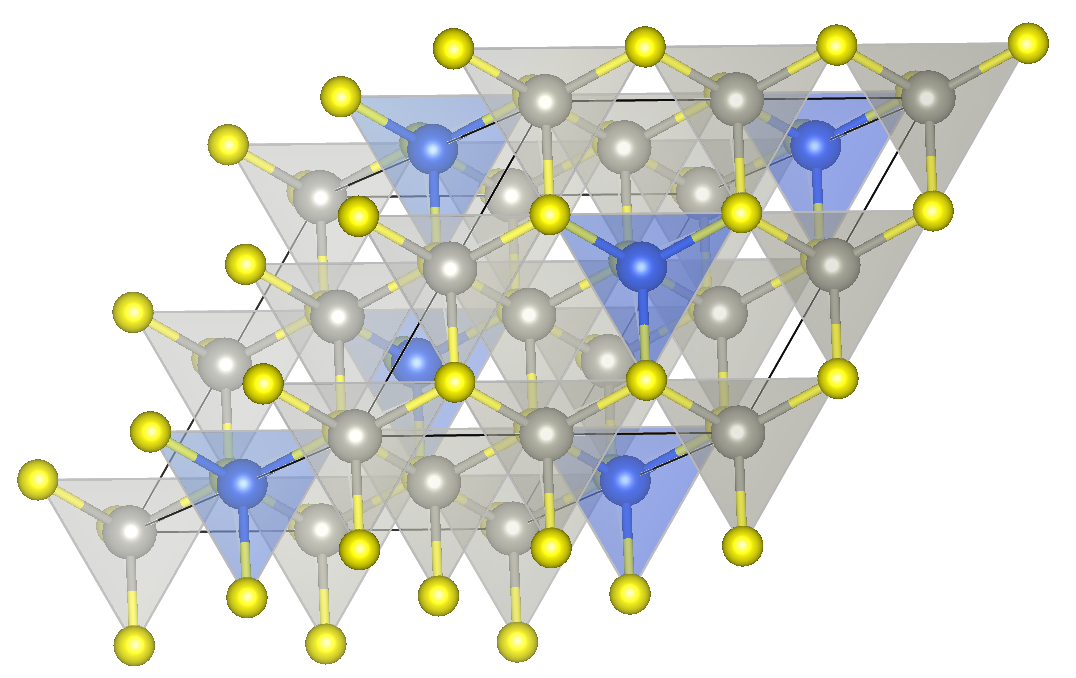

### 
### Bonus exercise: Try your own transformation

Set a new composition, e.g. x = 1/2

# 
# 4. Calculate new properties!

### 
### LESSON: volume prediction and XRD plot

###### 
###### Pymatgen has a data-mined lattice scaling (DLS) scheme that relies on data-mined bond lengths to predict the crystal volume of a given structure.
- We apply this here to create a starting point structure, which we can then fine-tune with DFT structure relaxation.
- DISCLAIMER! It's a bit janky, and is NOT a substitute for a DFT relaxation!!!

In [60]:
from pymatgen.analysis.structure_prediction.volume_predictor import DLSVolumePredictor

In [61]:
v = DLSVolumePredictor()
ordered_structure_guess = v.get_predicted_structure(ordered_structure)

In [62]:
print(ordered_structure_guess)

Full Formula (Zn6 Cu2 S8)
Reduced Formula: Zn3CuS4
abc   :   7.597133   7.597133   7.597133
angles:  60.000000  60.000000  60.000000
Sites (16)
  #  SP        a      b      c    magmom
---  ----  -----  -----  -----  --------
  0  Zn2+  0      0      0             0
  1  Zn2+  0      0.5    0             0
  2  Zn2+  0      0.5    0.5           0
  3  Zn2+  0.5    0      0             0
  4  Zn2+  0.5    0      0.5           0
  5  Zn2+  0.5    0.5    0.5           0
  6  Cu+   0      0      0.5           0
  7  Cu+   0.5    0.5    0             0
  8  S2-   0.125  0.125  0.125        -0
  9  S2-   0.125  0.125  0.625        -0
 10  S2-   0.125  0.625  0.125        -0
 11  S2-   0.125  0.625  0.625        -0
 12  S2-   0.625  0.125  0.125        -0
 13  S2-   0.625  0.125  0.625        -0
 14  S2-   0.625  0.625  0.125        -0
 15  S2-   0.625  0.625  0.625        -0


###### 
###### Your next step would be to relax this new structure using DFT

#### 
#### Calculate XRD, compare to original structure

now, we can compare this structure to our original structure to, for example, see how the XRD patterns shift

In [63]:
from pymatgen.analysis.diffraction.xrd import XRDCalculator

In [64]:
xrd = XRDCalculator(wavelength='CuKa')

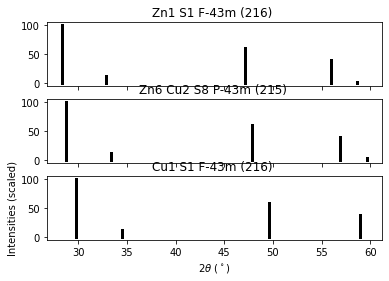

In [65]:
xrd_plots = xrd.plot_structures([ZnS_structure, ordered_structure_guess, CuS_structure], annotate_peaks=False, two_theta_range=[25,60])

you can see how the peaks shift slightly to the right with Cu integration!

### 
### Bonus exercise: try this on your own structure

<img src="next_steps.png" style="max-width:60%">